데이터 loaddata부터 오류가 떠서 추후에 좀 더 수정해서 올리겠습니다ㅜㅜ

*The Food-101 Data Set\
https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/ \
We introduce a challenging data set of 101 food categories, with 101'000 images.\
For each class, 250 manually reviewed test images are provided as well as 750 training images.\
 On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels.\
All images were rescaled to have a maximum side length of 512 pixels.

# 1. 데이터 불러오기

In [2]:
import torch
import torchvision
from torchvision import transforms, utils

이미지 변형하면서 가져오기

In [5]:
# 여러 transform 들을 Compose로 구성할 수 있습니다.

transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [ ]:
#데이터 다운로드
food = torchvision.datasets.Food101(
    root='/content/drive/MyDrive/쿠빅/딥러닝 방학세션',  # 데이터 저장 위치
    download=True,     # 다운로드 여부, (이미 다운받았으면 False로 지정)
    transform=transforms  # 데이터 선처리 작업
)

## 1.1 101가지는 너무 많아서 내가 좋아하는 15종류의 음식만 가져옴

In [7]:
food_list = ['apple_pie','chicken_wings','cheesecake','carrot_cake','chocolate_cake','french_fries','greek_salad','hamburger','hot_dog','ice_cream','pizza','ramen','tacos','waffles','sashimi']

In [10]:
import os
dir = '/content/drive/MyDrive/쿠빅/딥러닝 방학세션/food-101/images/'
dirs =[]
for i in food_list:
  dirs.append(os.path.join(dir,i))

In [11]:
food_fnames=[]
for j in dirs:
  food_fnames.append(os.listdir(j))

In [12]:
NUM_CATEGORIES = 15
#len(os.listdir(dir))

In [13]:
# numeric labeling
def get_food_labels(labels):
  text_labels = food_list
  return [text_labels[int(i)] for i in labels]

## 1.2 이미지 시각화

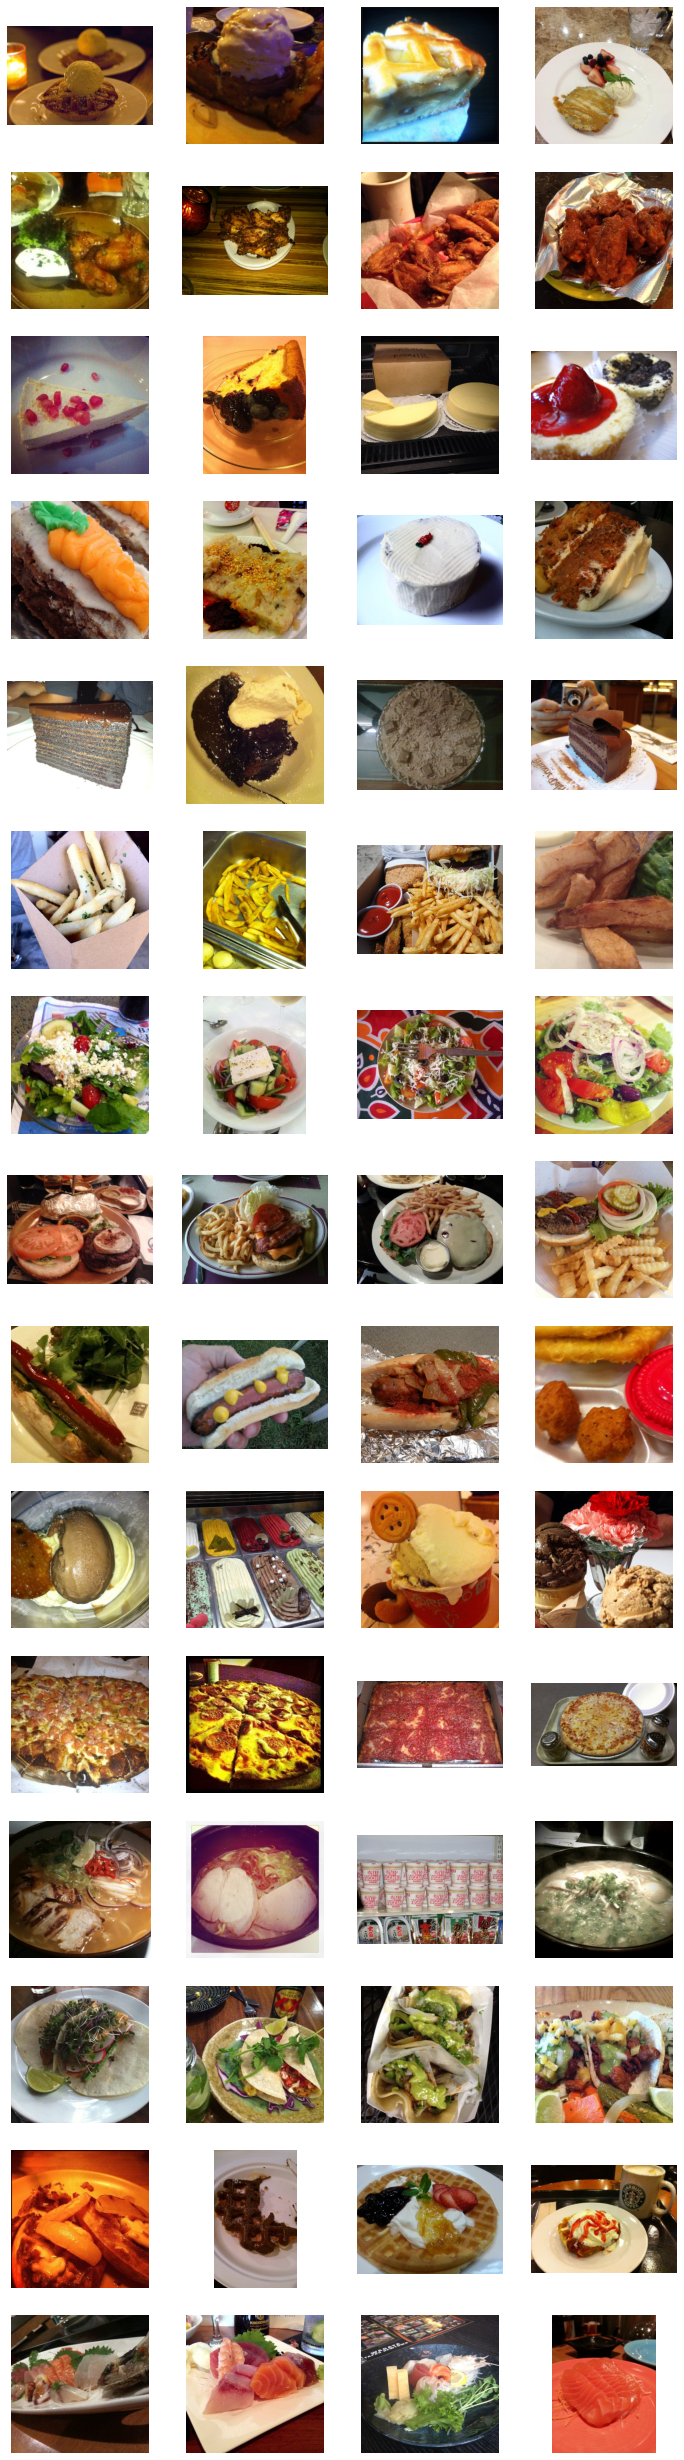

In [88]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

nrows, ncols = 15, 4
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols*3, nrows*3)

pictures = []
for i in range(15):
  pictures += [os.path.join(dirs[i], fname) for fname in food_fnames[i][0:4]]

for i, img_path in enumerate(pictures):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## 1.3 데이터 전처리

(1) 각 이미지에 대한 class label 할당

파일이름, label, 파일경로 dataframe 생성

In [14]:
import pandas as pd

label_df = pd.DataFrame()

pictures =[]
for i in range(15):
  pictures += [os.path.join(dirs[i], fname) for fname in food_fnames[i]]


In [16]:
len(pictures)

15000

In [79]:
#파일이름
names=[]

for i in range(len(food_fnames)):
  for j in range(1000):
    names.append(food_fnames[i][j])

In [80]:
label_df['file_name'] = names

label_df['label'] = ['apple_pie']*1000 + ['chicken_wings']*1000 + ['cheesecake']*1000 + ['carrot_cake']*1000 + ['chocolate_cake']*1000 + ['french_fries']*1000 + ['greek_salad']*1000 + ['hamburger']*1000 + ['hot_dog']*1000 + ['ice_cream']*1000 + ['pizza']*1000 + ['ramen']*1000 + ['tacos']*1000 + ['waffles']*1000 + ['sashimi']*1000

label_df['directory'] = pictures

(2) train set과 test set spilt 해주기

In [81]:
from sklearn.model_selection import train_test_split
import numpy as np

x_train, x_test, y_train, y_test = train_test_split(label_df['directory'], label_df['label'], test_size=0.2)    

(3) 전체 데이터셋 구성

사용자 정의 데이터셋

In [136]:
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None): #필요한 변수들을 선언
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index): #index번째 data를 return
        img_path = self.img_path_list[index]
        # Get image data
        image = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image
    
    def __len__(self): #길이 return
        return len(self.img_path_list)

tran = transforms.Compose([transforms.ToPILImage(), #Numpy배열에서 PIL이미지로
                           transforms.Resize([100,100]), #이미지 사이즈 변형
                           transforms.ToTensor()]) #이미지 데이터를 tensor

In [143]:
#CustomDataset class를 통하여 train dataset생성
train_dataset = CustomDataset(x_train, y_train, train_mode=True, transforms=tran)
test_dataset = CustomDataset(x_test, y_test, train_mode=False, transforms=tran)

In [138]:
# 사이즈
train_dataset[0][0].shape

torch.Size([3, 100, 100])

In [139]:
# 이미지와 label
train_dataset.__getitem__(1)

(tensor([[[0.6235, 0.3569, 0.3451,  ..., 0.1373, 0.1373, 0.1451],
          [0.5961, 0.3098, 0.3020,  ..., 0.1569, 0.1529, 0.1529],
          [0.5725, 0.2745, 0.2706,  ..., 0.1529, 0.1529, 0.1490],
          ...,
          [0.5333, 0.2000, 0.2039,  ..., 0.5176, 0.5059, 0.5059],
          [0.5294, 0.1922, 0.2000,  ..., 0.5412, 0.5490, 0.6000],
          [0.5137, 0.1569, 0.1647,  ..., 0.6706, 0.6902, 0.6667]],
 
         [[0.5569, 0.2275, 0.2314,  ..., 0.1333, 0.1333, 0.1412],
          [0.5373, 0.1922, 0.1922,  ..., 0.1529, 0.1490, 0.1490],
          [0.5216, 0.1686, 0.1647,  ..., 0.1490, 0.1451, 0.1451],
          ...,
          [0.4784, 0.0863, 0.0941,  ..., 0.3569, 0.3294, 0.3412],
          [0.4706, 0.0784, 0.0863,  ..., 0.3922, 0.3804, 0.4510],
          [0.4510, 0.0392, 0.0510,  ..., 0.5490, 0.5569, 0.5333]],
 
         [[0.5686, 0.2510, 0.2471,  ..., 0.2549, 0.2588, 0.2745],
          [0.5490, 0.2196, 0.2235,  ..., 0.2824, 0.2745, 0.2784],
          [0.5373, 0.2039, 0.2157,  ...,

In [146]:
#만든 train dataset를 DataLoader에 넣어 batch 만들기
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True, num_workers=0) #num_workers: cpu core 개수
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle=False, num_workers=0)

In [148]:
# 375개의 배치 (12000/32)
len(train_loader)

375

DATALOADER로 순회하기 -> 왜 오류뜨는지 모르겠음..ㅜㅜ

In [151]:
# loader 잘 됐는지 확인
import cv2
import matplotlib.pyplot as plt

train_features, train_labels = next(iter(train_loader))  #iter는 반복 가능한 객체에서 이터레이터를 반환하고, 
                                                        #next는 이터레이터에서 값을 차례대로 꺼냅니다. 
img = train_features[0]
label = train_labels[0]
plt.imshow(img[0], cmap="gray")
plt.show()
print(f"Label: {label}")

KeyError: ignored

# 2. Softmax 적용

In [ ]:
pip install d2l

In [170]:
from d2l import torch as d2l

## 2.1 Model parameters

In [156]:
num_inputs = 784
num_outputs = 10

W = np.random.normal(0, 0.01, (num_inputs, num_outputs))
b = np.zeros(num_outputs)


## 2.2 Define softmax operation

In [152]:
def softmax(X):
  X_exp = np.exp(X)
  partition = X_exp.sum(1, keepdims=True)
  return X_exp / partition

In [ ]:
X = np.random.normal()

## 2.3 Define the Model

In [153]:
def net(X):
  return softmax(np.dot(X.reshape((-1, W.shape[0])), W)+b)

## 2.4 Define the loss function

In [157]:
def cross_entropy(y_hat, y):
  return - np.log(y_hat[range(len(y_hat)), y])

## 2.5 Accuracy

In [160]:
def accuracy(y_hat, y):
  if len(y_hat.shape) > 1 and y_hat.shape[1] >1:
    y_hat = y_hat.argmax(axis=1)
  cmp = y_hat.astype(y.dtype) == y
  return float(cmp.astype(y.dtype).sum())

In [159]:
def evaluate_accuracy(net, data_iter):

  metric = Accumulator(2) 

  with torch.no_grad():
    for X, y  in data_iter:
      metric.add(accuracy(net(X), y), y.numel())
  return metric[0] / metric[1]

In [161]:
class Accumulator: 
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

## Training

In [172]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [176]:
linear = nn.Linear(10000, 10, bias=True)

In [177]:
# 비용 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss() # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

In [162]:
def train_epoch_ch3(net, train_iter, loss, updater):

  #sum of training loss, sum of trainig accruacy, number of examples
  metric = Accumulator(3)
  if isinstance(updater, gluon.Trainer):
    

In [163]:
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [164]:
def train_ch3(net, trian_iter, test_iter, loss, num_epochs, updater):

  animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
  
  for epoch in range(num_epochs):
    train_metrics = train_epoch_ch3(net, trian_iter, loss, updater)
    test_acc = evaluate_accuracy(net, test_iter)
    animator.add(epoch +1, train_metrics + (test_acc,))
  
  train_loss, train_acc= train_metrics

  #조건 반환 문
  # assert train_loss < 0.5, train_loss
  # assert train_acc <=1 and train_acc >0.7, train_acc
  # assert test_acc<=1 and test_acc>0.7, test_acc
  print(train_loss, train_acc)
  return

In [165]:
lr = 0.2

def updater(batch_size):
  return d2l.sgd([W,b], lr, batch_size)

In [171]:
num_epochs = 10

train_ch3(net,train_loader, test_loader, cross_entropy, num_epochs, updater)

KeyError: ignored

ImportError: ignored

<Figure size 252x180 with 1 Axes>

In [ ]:
def predict_ch3(net, test_iter, n = 6):

    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
        break
    trues = [int(i) for i in y]
    preds = [int(i) for i in net(X).argmax(axis=1)]
    titles = [str(true) +'\n' + str(pred) for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)